# Importing Data

Before all else, the data must be properly import, in this case, through the use of `pandas.read_csv()`.

In [1]:
import pandas as pd

# define a function for code reproducability later one (more seasons, inclusion of more pitchers, etc.)
def read_pitch_data(path):
    '''
    Reads in csv files for a given absolute or relative path.
    '''
    try:
        df = pd.read_csv(path)
        return df
    except FileNotFoundError as e:
        print(f'{e}\nRerun with an existing filename.')

In [2]:
train = read_pitch_data('Q1_pitches_train.csv')
test = read_pitch_data('Q1_pitches_test.csv')

And view the first few rows of the dataframes to ensure error-free imports: 

In [3]:
train.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,FF,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,FT,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,FF,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,SL,6,1,1,460,1100,2050


In [4]:
test.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,NaN,NaN,NaN,NaN,NaN
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,NaN,NaN,NaN,NaN,NaN
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,NaN,NaN,NaN,NaN,NaN
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN


Looks good! Some potential issues that could arise with this method include an unconventional delimiter (tab | ;) or an incorrect index column.

# Data Interpretation

There are some columns that are easy to understand by just observation like `inning`, `balls`, `strikes`, or `outs_before`. Yet some remain obscure like `basecode_before` or `cid`. Further analysis is needed, namely viewing using `df.info()` to view the data-types, as well as other key attributes.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480915 entries, 0 to 480914
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   inning            480915 non-null  int64 
 1   is_bottom         480915 non-null  int64 
 2   balls             480915 non-null  int64 
 3   strikes           480915 non-null  int64 
 4   outs_before       480915 non-null  int64 
 5   is_lhp            480915 non-null  int64 
 6   is_lhb            480915 non-null  int64 
 7   pitch_type        480915 non-null  object
 8   bat_score_before  480915 non-null  int64 
 9   field_score       480915 non-null  int64 
 10  basecode_before   480915 non-null  int64 
 11  batterid          480915 non-null  int64 
 12  pitcherid         480915 non-null  int64 
 13  cid               480915 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 51.4+ MB


There are 13 columns, all of type int64 (numeric w/ 64 bit capacity) except `pitch_type` which is of type object (string). 

In [7]:
train.select_dtypes(include = "object").head() # strings

,pitch_type
0,FF
1,FF
2,FT
3,FF
4,SL


The column `pitch_type` is the only non-numerical data-type and happens to be the label for this classification problem (i.e. aiming to predict pitch type).

In [8]:
train.select_dtypes(include = 'int64').head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,6,1,1,460,1100,2050


All of these numerical columns include information about the gamestate of the given pitch. In this way, though these are numerical figures, they have categorical meanings that are encoded. It is key to understand that by nature, this is a fundamentally different modeling problem than identifying a pitch given a certain spinrate or movement pattern. Instead, this model should predict the highest likelihoods for facing a pitch given the in game situation, with no relevant information about the pitch itself.

### Feature Domains

In addition to these standard data quality checks, it is imperative to understand all the possible values that features can take on:

In [9]:
print(train.nunique())

inning               19
is_bottom             2
balls                 4
strikes               3
outs_before           3
is_lhp                2
is_lhb                2
pitch_type            5
bat_score_before     23
field_score          23
basecode_before       8
batterid            988
pitcherid           830
cid                 113
dtype: int64


Immediately, there are assumptions that can be made about the domains of a few of the aforementioned more straightforward variables:

   - **inning**: the inning of the pitch - [1,20]
   - **is_bottom**: bottom/top half inning - binary {0,1}
   - **balls**, **strikes**, **outs_before**: gamestate before pitch - [0,3], [0,2], [0,2]
   - **is_lhp**, **is_lhb**: handedness of pitcher and batter - both binary {0,1},{0,1}
   - **bat_score_before**, **field_score**: score of teams before pitch - [0,22], [0,22]
   - **pitch_type** (label): type of pitch thrown - {'FF','SL','FT','CH','CB'}



And visualization of their distributions...

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# define a function for code reuse
def visualize_col_domains(col, df,c):
    """
    Visualizes categorical columns of a dataframe
    Parameters:
    col (str): the column name of the passed in dataframe
    df (DataFrame): the DataFrame to visualize cols
    """
    color = 'blue'
    if c%2 == 0:
        color = 'orange'
    plt.bar(df[col].value_counts().keys(), df[col].value_counts().values, color =color) # mets colors
    plt.xticks(ticks = np.arange(0,len(df[col].value_counts())), labels = df[col].value_counts().keys(),rotation = 45)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Counts of Categorical Column: {col}')
    

For the sake of practicality, it is important to limit the graphs to columns with a reasonable amount of possible values (excluding the id's). 

In [11]:
reasonable_domains = []
for col in train.columns:
    if(len(train[col].value_counts()) <= 23):
        reasonable_domains.append(col)

In [12]:
reasonable_domains

['inning',
 'is_bottom',
 'balls',
 'strikes',
 'outs_before',
 'is_lhp',
 'is_lhb',
 'pitch_type',
 'bat_score_before',
 'field_score',
 'basecode_before']

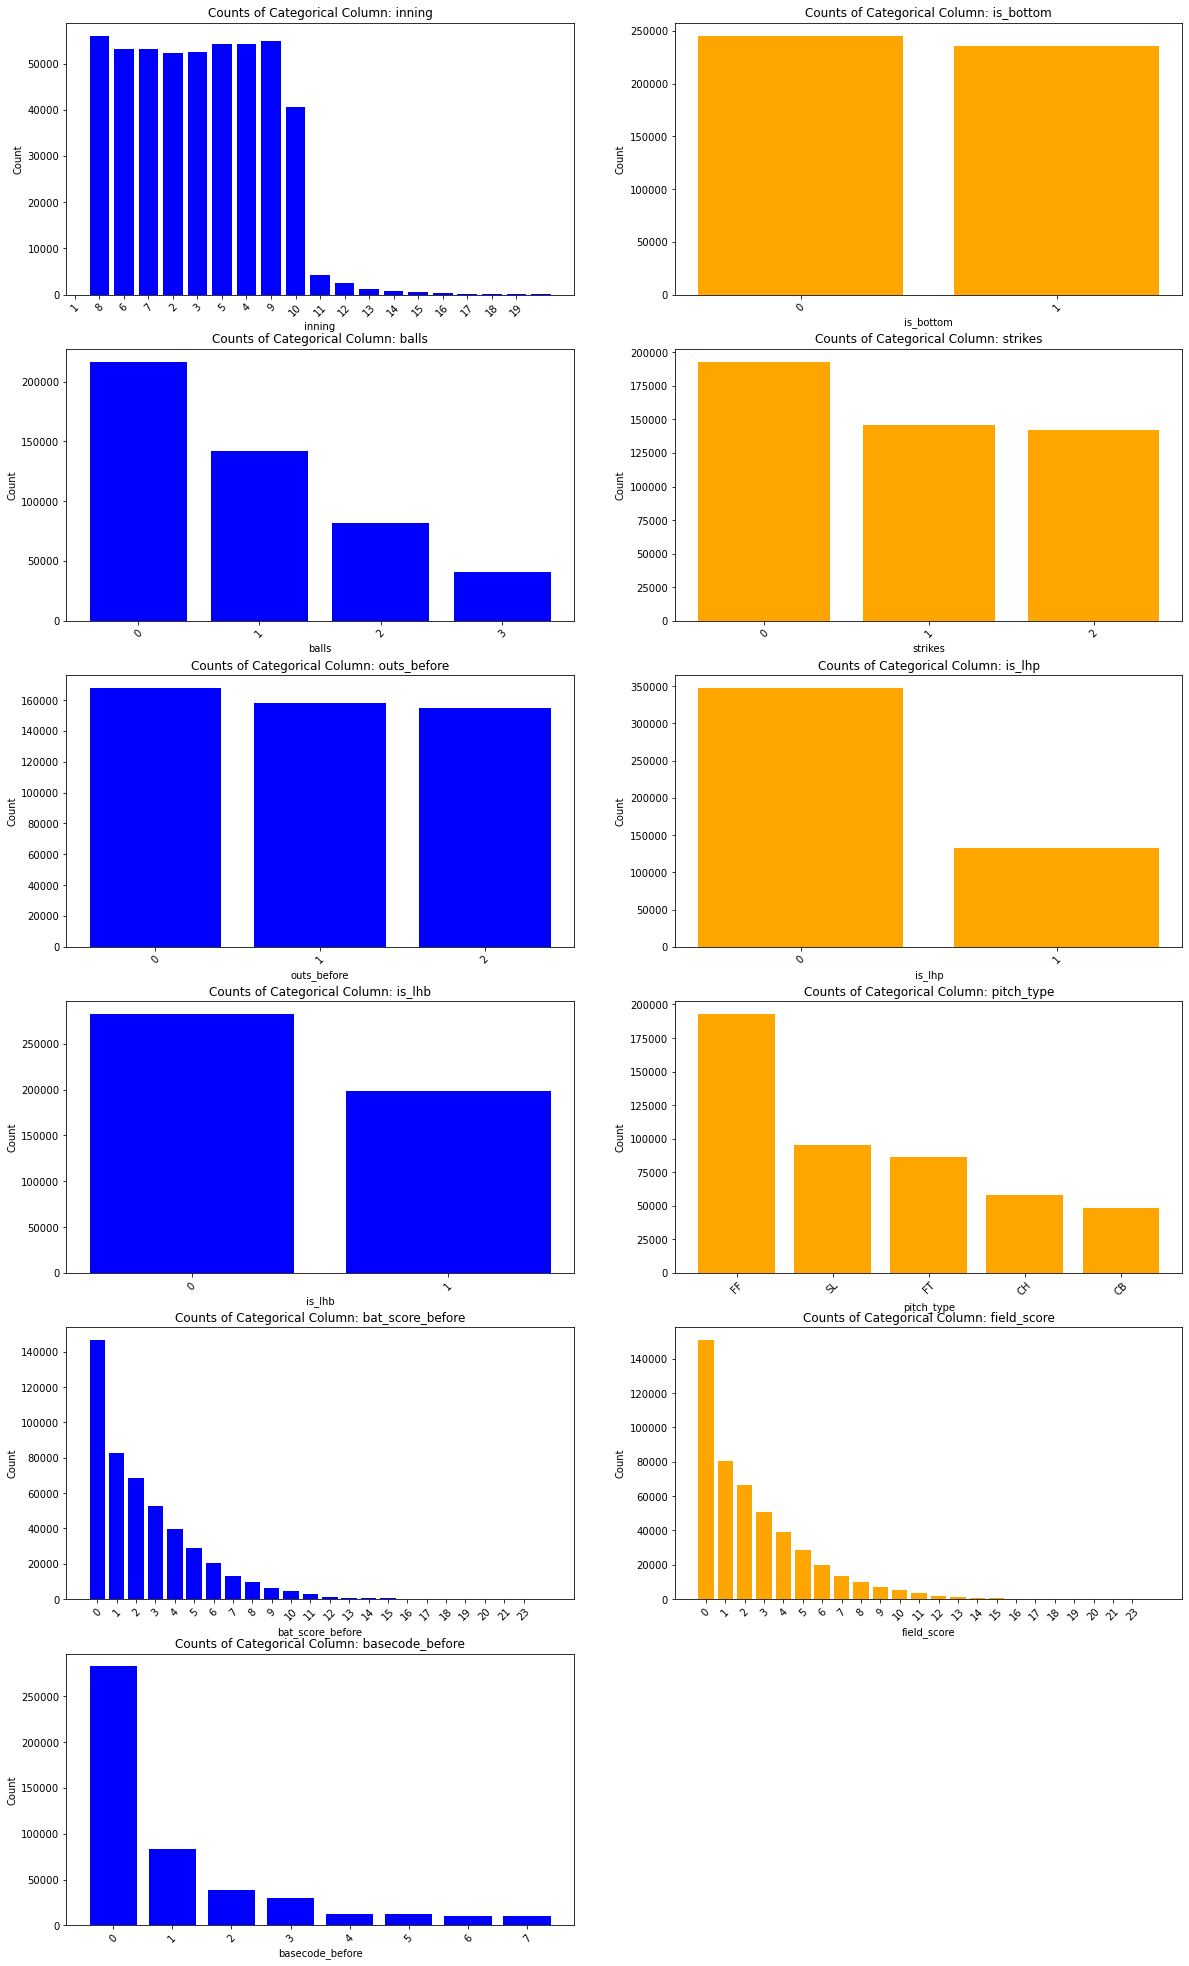

In [13]:
plt.figure(figsize =(20,35))
for i in range(1,len(reasonable_domains)+1):
    plt.subplot(6,2,i)
    visualize_col_domains(reasonable_domains[i-1],train,i)
plt.show()


This data mirrors their likely rate of occurences in MLB games. Innings remain constant for innings 1 through 9 then decrease for each extra inning, most pitchers and hitters are righties, and more 0 strike 0 ball and 0-0 game pitches.

The most influential visualization is of the labels - pitch type. Again following this real-world based hypothesis, one would expect the most 4-seam fastballs. This is the case, and it signifies that any model will 'learn' the gamestates that signify a fastball the closest. Subsequent accuracy analysis should display this. With this being said, however, the sheer number of sample pitches of each type (at least 50,000 each) assuages fears of a real, imbalanced model.

So, there remains two columns that are harder to understand: `basecode_before` and `cid`.

First, `basecode_before`

In [14]:
train['cid'].value_counts()

2032    12508
2024    12180
2005    12097
2014    11826
2020    10629
        ...  
2110      138
2095       97
2087       79
2112       15
2106        9
Name: cid, Length: 113, dtype: int64

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160306 entries, 0 to 160305
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   inning            160306 non-null  int64  
 1   is_bottom         160306 non-null  int64  
 2   balls             160306 non-null  int64  
 3   strikes           160306 non-null  int64  
 4   outs_before       160306 non-null  int64  
 5   is_lhp            160306 non-null  int64  
 6   is_lhb            160306 non-null  int64  
 7   bat_score_before  160306 non-null  int64  
 8   field_score       160306 non-null  int64  
 9   basecode_before   160306 non-null  int64  
 10  batterid          160306 non-null  int64  
 11  pitcherid         160306 non-null  int64  
 12  cid               160306 non-null  int64  
 13  FF                0 non-null       float64
 14  FT                0 non-null       float64
 15  CB                0 non-null       float64
 16  SL                0 

There are 160,306 test pitches, significantly less than the training pitches. 

There are some columns present in the testing set, that are not in the training set (and vice-versa).

In [16]:
for col in train.columns:
    if col not in test.columns:
        print(f"Column '{col}' in train data but not test data.")

for col in test.columns:
    if col not in train.columns:
        print(f"Column '{col}' in test data but not train data.")

Column 'pitch_type' in train data but not test data.
Column 'FF' in test data but not train data.
Column 'FT' in test data but not train data.
Column 'CB' in test data but not train data.
Column 'SL' in test data but not train data.
Column 'CH' in test data but not train data.


The first of these discrepencies is trivial: the label SHOULD be absent from the test data. The only other differences are the names of pitch types, which become more comprehensible when viewed below.

In [17]:
test[['FF','FT','CB','SL','CH']]

,FF,FT,CB,SL,CH
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
160301,NaN,NaN,NaN,NaN,NaN
160302,NaN,NaN,NaN,NaN,NaN
160303,NaN,NaN,NaN,NaN,NaN
160304,NaN,NaN,NaN,NaN,NaN


These columns prove to be placeholders for the required format of the output. The predictions 
should mirror the pattern typical of a dummy variable instead of in a single column. A dummy variable is typically used to explode a categorical variable by having separate columns for each possible output, with 0's for the absense and 1 for the presence. 

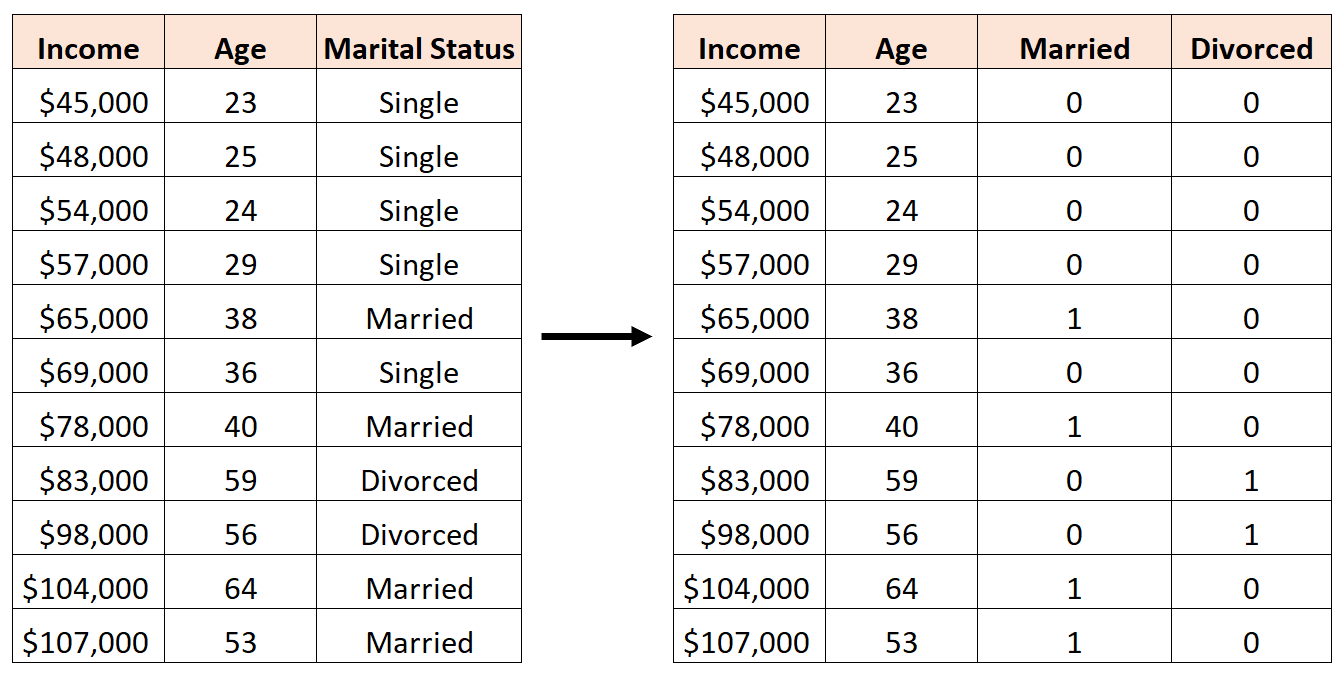

This output requirement should be noted.

### Duplicate Check

In [18]:
def check_dupes(df):
    if (df.duplicated().sum() == 0): # duplicated () checks each row for dupe
        print("No row is a duplicate entry.")
    else:
        print("There is at least one duplicate entry.")

In [19]:
check_dupes(train)
check_dupes(test)

There is at least one duplicate entry.
There is at least one duplicate entry.


There proves to be duplicate pitches present in the dataset for both training and testing pitches. This makes sense, however, due to the categorical nature of all features. Two duplicate entries can simply occur in the following scenerio: the same 2 strike pitch after a foul within the same at bat.

In [20]:
dupes = train[train.duplicated(keep=False)]
dupes

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
62,8,1,1,2,1,0,0,SL,1,0,0,220,1254,2071
69,9,0,3,2,2,1,0,FF,6,2,4,127,1441,2025
146,5,0,2,2,0,1,0,FF,0,4,0,88,1499,2043
153,6,0,2,2,1,1,0,FF,4,0,0,446,1287,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480779,9,1,1,2,0,0,0,SL,0,3,1,596,1451,2003
480825,7,1,3,2,1,1,0,SL,2,6,0,244,1288,2071
480836,7,0,3,2,2,0,1,SL,1,2,0,45,1082,2008
480896,2,1,1,2,1,0,0,SL,0,0,6,171,1122,2003


This is only a modicum of total pitches in the training set, however, it is nonetheless important to account for their appearance.

For illustration, view the first duplicatated pitch (which happens to be of index 1).

In [21]:
dupes.loc[((train['pitcherid'] == dupes.loc[1,'pitcherid']) & (train['batterid'] == dupes.loc[1,'batterid']))]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
84191,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052


Now, view the non-two strike instances.

These are bound to be rarer, as they are required to happen in separate games. Still, within divisional rivalries, pitchers can face an opposing batter multiple times a season with identical gamestates. The vast majority occurring with SP against 1, 2 or 3 hitters in the lineup (i.e. 0-0 top 1st/bottom 1st).

In [22]:
dupes.loc[dupes['strikes'] != 2]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
309,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
1541,1,0,0,0,0,0,1,FF,0,0,0,506,1416,2003
2162,1,0,0,1,0,0,1,FF,0,0,0,430,1500,2009
2238,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015
4395,2,1,0,0,1,0,1,FF,0,0,0,544,1654,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476607,1,0,0,0,0,0,0,FF,0,0,0,330,1256,2049
478670,4,1,0,1,0,1,1,CH,1,2,0,460,1059,2018
480247,1,1,0,0,1,0,1,CB,0,0,2,76,1048,2029
480599,1,1,0,0,0,0,1,FF,0,0,0,182,1279,2054


In [23]:
dupes.loc[((train['pitcherid'] == dupes.loc[309,'pitcherid']) & (train['batterid'] == dupes.loc[309,'batterid']))]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
309,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
31169,1,0,0,0,1,1,0,FT,0,0,0,7,1012,2002
52944,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
97483,1,0,0,0,1,1,0,FT,0,0,0,7,1012,2002


Once the gamestate advances past the first few innings, it becomes exponentially more unlikely that these persistent duplicates would be due to their actual occurrences, rather than an error in data entry or engineering. Now, these pitches can be sorted out. The logic to identify these will be to filter entries when either team had two runs or less.

In [24]:
dupes.loc[((dupes['strikes'] != 2) &\
            (dupes['inning'] != 1) &\
             (dupes['bat_score_before'] >=2) & \
              (dupes['field_score']>=2))]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
2238,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015
101437,8,0,1,1,0,0,1,FF,5,7,0,1,1215,2000
320203,8,0,1,1,0,0,1,FF,5,7,0,1,1215,2000
343587,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015


THESE DUPES ARE SIGNIFICANT

SAME FOR TEST

### Null Check

Now, a final null check...

In [25]:
def check_nulls(df):
    if(train.isna().sum().sum() == 0):
        print("No row contains a null or NaN value.")
    else:
        print("There is a null or NaN value in this table.")

In [26]:
check_nulls(train)

No row contains a null or NaN value.


# Exploratory Analysis -  Value Interpretation

### Pitch Analysis

In [27]:
t_by_pitcher = test.groupby(['pitcherid']) # creates groupby object that needs aggregation function, much like in SQL
a = t_by_pitcher.count().iloc[:,0] # count agg function and has all identical columns
a.name = "Test Pitches" # rename
a

pitcherid
1000    198
1001    275
1002    315
1003    221
1004    235
       ... 
1825     20
1826     12
1827      1
1828     64
1829      6
Name: Test Pitches, Length: 827, dtype: int64

In [28]:
tr_by_pitcher = train.groupby(['pitcherid'])
b = tr_by_pitcher.count().iloc[:,0]
b.name = 'Train Pitches'
b

pitcherid
1000    585
1001    835
1002    996
1003    637
1004    658
       ... 
1825     46
1826     34
1827     16
1828    161
1829      8
Name: Train Pitches, Length: 830, dtype: int64

These counts drastically shift between the training and testing set. Despite pitcher 3 only having a handful of training pitches recorded, there are many to predict. Similarly, pitcher 6's lack of any recorded training pitches is striking. A double bar plot illustrates this further.

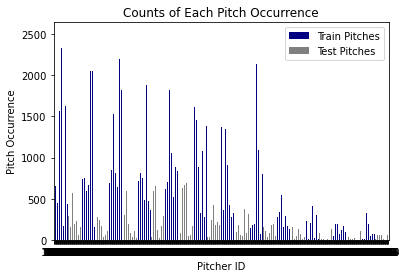

In [29]:
import matplotlib.pyplot as plt

temp = pd.DataFrame(data = [b,a]).T # set up data for graphing
temp.loc[6,'Train Pitches'] = 0


temp.plot(kind='bar',color = ['Navy','Grey'])
plt.title('Counts of Each Pitch Occurrence')
plt.xlabel('Pitcher ID')
plt.ylabel('Pitch Occurrence')
plt.legend()
plt.xticks(rotation = 0)
plt.show()

Most importantly, the number of pitches from each pitcher differs greatly from training set to test set and this follows no consistent pattern. In the training set, pitches from pitcher 5 sky over the others (including essentially none from pitchers 3 and 6), while the testing set has a balanced sample.

Next, grouping the training set by both `pitcherid` and `type` reveals perhaps the most important insight. Key features that are amongst the most useful for pitch prediction (i.e. `spinrate`, `break`) differ greatly from one pitcher to the next. Let's take a look at this...



Only two pitch types are present in each pitcher's repertoire: pitch 9 and pitch 10. Vital pitch figures are gathered and plotted below. 

In [30]:
pitch_nine_sr= []
pitch_nine_breakx= []
pitch_nine_breakz= []

pitch_ten_sr= []
pitch_ten_breakx= []
pitch_ten_breakz = []

# iteratively gathering values for pitcher 1 - 5 
for i in range(1,6):
    pitch_nine_sr.append(grouped_by_pitcher_and_pitchtype.loc[(i,9),'spinrate'])
    pitch_nine_breakx.append(grouped_by_pitcher_and_pitchtype.loc[(i,9),'breakx'])
    pitch_nine_breakz.append(grouped_by_pitcher_and_pitchtype.loc[(i,9),'breakz'])
    
    pitch_ten_sr.append(grouped_by_pitcher_and_pitchtype.loc[(i,10),'spinrate'])
    pitch_ten_breakx.append(grouped_by_pitcher_and_pitchtype.loc[(i,10),'breakx'])
    pitch_ten_breakz.append(grouped_by_pitcher_and_pitchtype.loc[(i,10),'breakz'])
    

# plot in matplotlib subplots
lists = [pitch_nine_sr,pitch_nine_breakx,pitch_nine_breakz,pitch_ten_sr,pitch_ten_breakx, pitch_ten_breakz]
titles = ['Pitch 9 spinrate','Pitch 9 x-break','Pitch 9 z-Break','Pitch 10 spinrate','Pitch 10 x-break','Pitch 10 z-Break']

plt.figure(figsize =(20,10))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.plot(lists[i-1],marker = 'o',color = 'navy')
    
    # title subplots for which value
    plt.title(titles[i-1])
    plt.xticks(ticks = range(0,5), labels = range(1,6))
    
    # format graph
    if(i == 4 or i == 1):
        plt.ylabel('Pitch Value')
    plt.xlabel('Pitcher')

plt.tight_layout()
plt.show()

NameError: name 'grouped_by_pitcher_and_pitchtype' is not defined

This poses a problem to the ultimate goal of pitch prediction: if key values vary greatly for the same pitch by different pitchers, then it becomes very difficult to predict. 

Moreover, there seems to be a common outlier. Pitcher 3 pitch values are drastically different than the others especially for the `breakx` feature. Upon further review, there is a key insight that can be gathered by focusing on the `initposx` values...

### Feature Selection

Immediately, quite a few columns jump out as being superfluous. `height` is irrelevant to pitch type. In other words, a 72 inch pitcher is not more likely to throw a certain pitch than a 77 inch pitcher. This feature is irrelevant to the model training, and would only complicate matters.

In [ ]:
train.drop('height',inplace = True, axis = 1)
test.drop('height',inplace = True, axis = 1)

The `df.describe` function provides descriptive statistics of a DataFrame's columns.

"Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset." 
- pandas documentation

In [ ]:
train.describe()['extension']

For one of these, `extension`, the ratio of std dev to mean is miniscule. This value, called the coefficient of variation or CV, signifies an extremely low variability in this column. In other words, assuming a somewhat normal distribution, a large percentage (95%) of `extension` fall within 2 standard deviations of the mean. Here, that would be $$\mu \pm 2\sigma = 6.199 \pm 0.3999  \approx [5.8,6.6] $$
which is not a large range.

It follows that `extension` cannot be an important feature in this model because it virtually identical for all pitches.

In [ ]:
train.drop('extension',inplace = True, axis = 1)
test.drop('extension',inplace = True, axis = 1)

Next, filtering amongst pitchers of the same handedness reveals deeper insight into some measures of central tendency of the intial positions of the release.

In [ ]:
test.loc[test['righty'] == 1,['initposx','initposz']].describe()

In the same way as `extension `, `initposz` does not vary largely at all for each pitcher. Despite a higher relative CV, upon reflection, the `initposx` can be ignored as well. Even when filtering for handedness, differences in x coord release point is more likely to be due to biometric differences between pitchers like wingspan and height compared to variation in pitch type. The one exception to this assumption would be a pitcher tipping. When a pitcher tips, a release point change (or other factor) can be a direct signifier of pitch type, but that conclusion is not based on evidence in these sample pitches. 

In [ ]:
train.drop(['initposz','initposx'],inplace = True, axis = 1)
test.drop(['initposz','initposx'],inplace = True, axis = 1)

In [ ]:
print(train.columns)
print(test.columns)

Finally, the `yearid` and `pitcherid` are informative features that are categorical, thus not belonging as a part of the feature space of continuous pitch data. These were necessary for data understand, but should not continue being a part of the training and testing set. 

In [ ]:
train.drop(['yearid','pitcherid'],inplace = True, axis = 1)
test.drop(['yearid','pitcherid'],inplace = True, axis = 1)

In [ ]:
assert len(train.columns) == 6 and len(test.columns) == 5 # assert only chosen features (and label for training set)

### Preventing Multicolinearity

The last step before model training is to check for multicolinearity.

Colinearity can be seen as the propensity to which two independent, predictor variables have a linear relationship each other. When this occurs, it is impossible to measure what is affecting the dependent variable, and leads to an increased p-value for each coefficient. This signifies decreased statistical significance of the findings.

There are many ways to allieviate this, but perhaps the most simple, is to drop one of a colinear pair of variables. This should be done carefully and key features should be preserved. To judge for colinearity, a view of the correlation pairs of each feature are displayed below.

In [ ]:
import seaborn as sns

corr = train.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr.round(2), vmax = 1, vmin = -1, center = 0, annot =True, cmap = 'coolwarm')
plt.show()

Given the amount of features, the lack of extreme colinearity bodes well for modelling. The highest correlation between features is inning's correlation with the team scores. This is quite obvious, as more runs will be scored as the inning number increases. 

# Model Selection

### Procedure

# Modeling

KNN RF

In [ ]:
train

In [ ]:
X_train = train.copy()

In [ ]:
y_train = X['pitch_type']
X_train.drop(['pitch_type'],axis = 1, inplace = True)

The `batterid`,`pitcherid` and `cid` are all preserved in the `train` DataFrame, but unnecessary to include in modelling step. 

In [ ]:
X_train

Finally, modeling can begin. The data will be split into the feature vector X (for each feature x, $X = x_1, x_2,...x_n$) and the label vector, $y$ for both righty and lefty training sets.

Since this data is already split into training and testing sets, there is no need to split it again for that purpose. However, there is a benefit to doing this for another reason: the validation set. 

The validation set provides an evaluation of the models fit to the data, and allows for hyperparameter tuning before finalization. This is fundamentally analagous to the test set, but is a subset of the training set. It is of the utmost importance to prevent the model from 'seeing' the test set, until final model scoring. 

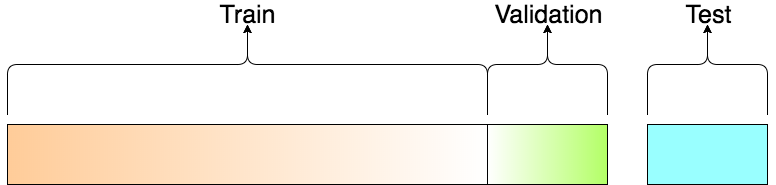

kNN or k-Nearest Neighbors is a non-linear model type "for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to." [source](https://learn.g2.com/k-nearest-neighbor)

This includes two types of models: kNN classifier or kNN regressor. The former categorizes a 'best guess' based on the a consensus of the k nearest points, while the latter predicts a continuous variable. For example, a kNN classifier might predict a pitch of being type 10, while a regressor might predict a score of 9.42 for the same pitch.

In this case, a classifier is clearly the better choice due to the numerical, yet categorical label of `type`. 

One important preliminary step of kNN models is to scale the data. Because these models depend on Euclidean distance, scaling the data prevents that which has much larger scale (like spinrate ~2600 vs. break <10) from overinfluence the model predictions. In this case, a standard scalar and Min-Max Scalar are used.

StandardScalar removes variance and reverts data to its z-score $$z = \frac{x-\mu}{\sigma}$$ while a MinMaxScalar simply normalizes data to values preserving relative distance but in $[0,1]$ using the formula $$x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)}$$


Before fitting on the test set, hyperparameter tuning needs to be done. This is the process of iteratively testing different user-controlled variables of models such as: learning rate alpha in linear regression, max depth of a decision-tree, design and layers of a deep learning model, number of neighbors in kNN, etc.

In this case, using a validation set for tuning has added benefits; the validation set is labelled as it is a subset of the training set. Therefore, an accuracy score can be determined. This cannot be done for the unlabelled test set.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


def best_performing_hyperparameters(X_handedness, y_handedness):
    """
    A manuel version of a gridsearch for kNN pitch modeling. Determines best values for hyper
    parameters using cross validation
    @ param: X_handedness: dataframe containing training pitches
    @ param : y_handedness: array containing training labels 
    @ return: std_accuracies: accuracies for std scalar
    @ return: mm_accuracies: accuracies for mm scalar
    """
    std_accuracies = []
    min_max_accuracies = []
    for i in range(5,50,5):

        X_train, X_val, y_train, y_val  = train_test_split(X_handedness, y_handedness, test_size=0.2, random_state=i) # different validation set split (cross validation)

        # s-scalar
        scaler = StandardScaler()
        scaler.fit(X_train) # fit scalar on training set...
        X_train = scaler.transform(X_train) # and transform both...
        X_val = scaler.transform(X_val)
        knn = KNeighborsClassifier(n_neighbors=i) 


        knn.fit(X_train,y_train)
        test_predictions = knn.predict(X_val)
        test_accuracy = accuracy_score(test_predictions, y_val)
        std_accuracies.append(test_accuracy)


        #mm-scalar
        scaler = MinMaxScaler()
        scaler.fit(X_train) # fit scalar on training set...
        X_train = scaler.transform(X_train) # and transform both...
        X_val = scaler.transform(X_val)
        knn = KNeighborsClassifier(n_neighbors=i) 

        knn.fit(X_train,y_train)
        test_predictions = knn.predict(X_val)
        test_accuracy = accuracy_score(test_predictions, y_val)
        min_max_accuracies.append(test_accuracy)
    return (std_accuracies,min_max_accuracies)


In [ ]:
def graph_hyperparameters(std_acc, mm_acc, righty):
    """
    Prints the results and corresponding graphs of various pitch model hyperparams
    @ param: std_acc list containing accuracy using std. scalar
    @ param: mm_acc list containing accuracy using mm. scalar
    @ param: righty boolean righty lefty model
    """
    handedness = 'Right'
    if (not righty):
        handedness = "Left"
    print(f'For {handedness} handed pitch prediction...')
    print(f'The highest performing "number of neighbors" for kNN pitch prediction when scaled using StandardScalar is {max(std_acc):0.2%} with number neighbors {5+5*std_acc.index(max(std_acc))}.')
    print(f'The highest performing "number of neighbors" for kNN pitch prediction when scaled using MinMaxScalar is {max(mm_acc):0.2%} with number neighbors {5+5*mm_acc.index(max(mm_acc))}.')
    plt.plot(std_acc,label = 'Standard Scalar',color = 'navy') # yankee colors!
    plt.plot(mm_acc,label = 'MinMax Scalar',color = 'grey') 
    plt.title(f'Accuracy Metrics of kNN with Different `k` values for {handedness} handed Pitch Prediction')
    plt.xlabel('Value of `k`')
    plt.ylabel('Accuracy (%)')
    plt.xticks(ticks = range(0,9),labels = range(5,50,5))
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train_righty, X_val_righty, y_train_righty, y_val_righty \
    = train_test_split(X_righty, y_righty, test_size=0.2, random_state=1) # random state for code reproducibility

print(X_train_righty.shape) # 10635*.8 = 8508 samples 
print(X_val_righty.shape) # 10635*.2 = 2127

In [ ]:
X_train_lefty, X_val_lefty, y_train_lefty, y_val_lefty \
    = train_test_split(X_lefty, y_lefty, test_size=0.2, random_state=1) # random state for code reproducibility

print(X_train_lefty.shape) # 10647*.8 = 8517 samples (includes extra 12 original lefty pitches)
print(X_val_lefty.shape) # 10647*.2 = 2130 

In [ ]:
righty_std_acc, righty_mm_acc = best_performing_hyperparameters(X_train_righty, y_train_righty)
graph_hyperparameters(righty_std_acc, righty_mm_acc, True)

In [ ]:
lefty_std_acc, lefty_mm_acc = best_performing_hyperparameters(X_train_lefty, y_train_lefty)
graph_hyperparameters(lefty_std_acc, lefty_mm_acc, False)

Despite similar performance, it is clear that the MinMax scalar with `k` = 15 prevails as the best scalar type to use for the righty model. For the lefty model, we will move forward with standard scaling with a `k` of the default 5.

Now, a pipeline will be used to train the respective models with the correct hyperparameters. A sci-kit learn pipeline is an object that consolidates multiple steps of the ML process that require fitting and transforming.

In [ ]:
from sklearn.pipeline import Pipeline

# for righty
X_train = X_righty.copy()
y_train = y_righty.copy()
X_test = test_righty.copy()

pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors=15))])
pipe.fit(X_train, y_train)
righty_predictions = pipe.predict(X_test)
         
# for lefty , redeclare train/test
X_train = X_lefty.copy()
y_train = y_lefty.copy()
X_test = test_lefty.copy()

pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])
pipe.fit(X_train, y_train)
lefty_predictions = pipe.predict(X_test)

Finally, the predictions are obtained.

Right now, these are each separated by handedness, and each `pitchid` needs to be combined and sorted. Converting the predictions into their own DataFrames and viewing the first rows of each dispays this.

In [ ]:
righty_predictions = np.array(righty_predictions).T # to orient correctly 
pitch_dict = {'pitchid':test_righty.index, 'pitch_type_prediction': righty_predictions} # obtain original pitchid with prediction
df_right = pd.DataFrame(pitch_dict) # form dataframe with col 1 == id, col 2 == prediction

lefty_predictions = np.array(lefty_predictions).T
pitch_dict = {'pitchid':test_lefty.index, 'pitch_type_prediction': lefty_predictions}
df_left = pd.DataFrame(pitch_dict)

In [ ]:
df_right.head()

In [ ]:
df_left.head()

The next and final step combines these preserving the ids. This is done via a stacking concatenation by way of an outer join. In an outer join, each unique entry of a common row is included. These predictions are then sorted, viewed, and sent to a .csv file for submission.

In [ ]:
preds = pd.concat([df_right,df_left],join = 'outer',ignore_index=False, axis = 0) \
.sort_values('pitchid').reset_index(drop = True)

preds.to_csv('pitchclassificationtestpredictions.csv')
preds.head()

In [ ]:
# final assertions for a sanity check

#assert length of preds is length of test pitches  
assert len(preds['pitchid']) == len(test.index)

# get feature space of pitch types predicted
all_pitch_types_pred = preds['pitch_type_prediction'].value_counts()\
.index.sort_values().to_numpy()

# all feature space of pitches in training sample
all_pitch_types_given = train['type'].value_counts()\
.index.sort_values().to_numpy()

# assert all pitch types are in the range of predictions
assert (all_pitch_types_pred == all_pitch_types_given).all()

# assert first pred id is first test id
assert preds.loc[0,'pitchid'] == test.index[0]